This notebook looks at how many "good" (R/B > 0.6) objects are found per COSMOS field image, and at how a candidate's average R/B score is correlated to the number of times it is detected.

In [1]:
# Login and database access
import psycopg2
import psycopg2.extras
import getpass

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Math
import numpy as np
import pandas as pd

# Custom
from decam_utils import *

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

DB User:  kennedyt
DB Password:  ············


In [3]:
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

In [4]:
db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

In [5]:
font = {'size'   : 16}

mpl.rc('font', **font)

#### How many "Good" (R/B>0.6) sources are identified per subtraction? (COSMOS)

In [6]:
query = ( 'SELECT o.id, o.subtraction_id, o.candidate_id, rbs.rb FROM objects o '
         'JOIN subtractions s ON o.subtraction_id = s.id '
         'JOIN exposures e ON s.exposure_id = e.id '
         'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'AND e.mjd < 59377 '
         'AND rbs.rb>0.6 '
         'LIMIT 10000000')

cursor.execute( query )

oidsidcid = np.array( cursor.fetchall() ).transpose()

In [7]:
oidsidcid = rm_dupes(oidsidcid,0)

2064 duplicates removed


In [8]:
# Find out how many objects are present in each subtraction (objspersub)
imgs, objspersub = np.unique( oidsidcid[1], return_counts=True )

Median is 2 objects per subtraction
Mean is 3.017250 objects per subtraction
Max is 138 objects per subtraction
Min is 1 object(s) per subtraction


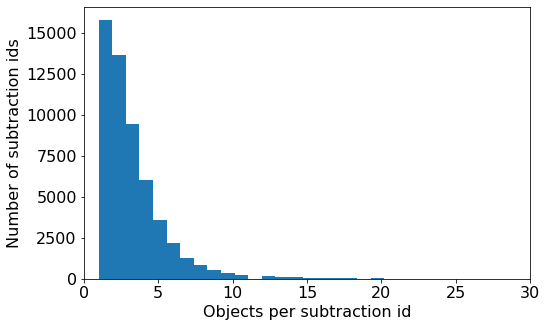

In [9]:
# Throw that data into a histogram
plt.figure( figsize = (8,5) )
plt.ylabel( "Number of subtraction ids" )
plt.xlabel( "Objects per subtraction id" )
plt.hist( objspersub, bins=150 )
plt.xlim( 0, 30 )
print( "Median is %i objects per subtraction" % ( np.median( objspersub ) ) )
print( "Mean is %f objects per subtraction" % ( np.mean( objspersub ) ) )
print( "Max is %i objects per subtraction" % ( np.max( objspersub ) ) )
print( "Min is %i object(s) per subtraction" % ( np.min( objspersub ) ) )

#### How many images have been processed so far? (COSMOS)

In [10]:
query = ( 'SELECT exposure_id FROM subtractions s '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(s.ra,s.dec,150,2.2,3) '
         'AND e.mjd < 59377 '
         'LIMIT 10000000' )

cursor.execute( query )

totsub = cursor.fetchall()

In [11]:
len( np.unique( totsub ) )

1117

#### How many exposures have been taken? (COSMOS)

In [12]:
query = ( 'SELECT COUNT(*) FROM exposures e '
         'WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) '
         'AND e.mjd < 59377 '
         'LIMIT 10000000' )

cursor.execute( query )

totexp = cursor.fetchall()[0][0]

In [13]:
totexp

1125

#### How many "Good" (R/B>0.6) sources are identified per exposure? (COSMOS & ELIAS)

In [14]:
query = ( 'SELECT o.subtraction_id, o.id, s.exposure_id, e.filter, o.candidate_id, rbs.rb FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON s.exposure_id=e.id '
         'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND e.mjd < 59377 '
         'AND rbs.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

Copiquery = np.array( cursor.fetchall() ).transpose()

query = ( 'SELECT o.subtraction_id, o.id, s.exposure_id, e.filter, o.candidate_id, rbs.rb FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON s.exposure_id=e.id '
         'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
         'WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,2) '
         'AND e.mjd < 59377 '
         'AND rbs.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

Eopiquery = np.array( cursor.fetchall() ).transpose()

In [15]:
Copiquery = rm_dupes( Copiquery, 1 )
Eopiquery = rm_dupes( Eopiquery, 1 )

2064 duplicates removed
19 duplicates removed


In [16]:
filters = Copiquery[3]
# Creating masks for each filter
Cgmsk = np.where( filters == 'g' )[0]
Crmsk = np.where( filters == 'r' )[0]
Cimsk = np.where( filters == 'i' )[0]

filters = Eopiquery[3]
# Creating masks for each filter
Egmsk = np.where( filters == 'g' )[0]
Ermsk = np.where( filters == 'r' )[0]
Eimsk = np.where( filters == 'i' )[0]

In [17]:
# Count frequencies of exposure IDs to find out how many objects come from each exposure in each of the three filters (COSMOS)
exp, opigc = np.unique( Copiquery[2][Cgmsk], return_counts=True )
exp, opirc = np.unique( Copiquery[2][Crmsk], return_counts=True )
exp, opiic = np.unique( Copiquery[2][Cimsk], return_counts=True )
del exp
opic = [opigc,  opirc, opiic]

# Count frequencies of exposure IDs to find out how many objects come from each exposure in each of the three filters (ELIAS)
exp, opige = np.unique( Eopiquery[2][Egmsk], return_counts=True )
exp, opire = np.unique( Eopiquery[2][Ermsk], return_counts=True )
exp, opiie = np.unique( Eopiquery[2][Eimsk], return_counts=True )
del exp
opie = [opige,  opire, opiie]

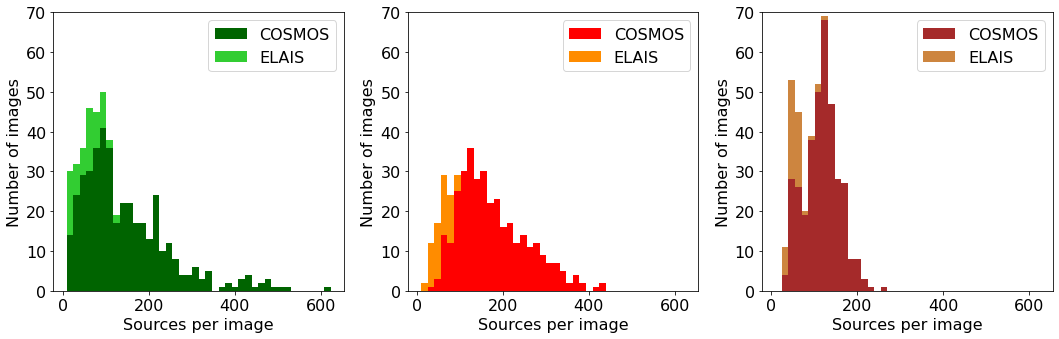

In [18]:
# Plotting
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True)
bins = np.histogram(opigc, bins=40)[1]
c = ['darkgreen', 'red', 'brown', 'limegreen', 'darkorange', 'peru']

for i in [0,1,2]:
    ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].hist( [opic[i],opie[i]], bins, stacked=True, color=[c[i],c[i+3]], label=['COSMOS','ELAIS'])
    ax[i].set_xlabel( "Sources per image" )
    ax[i].set_ylabel( "Number of images" )
    ax[i].set_ylim(0,70)
    ax[i].legend()

fig.tight_layout()
plt.savefig("./images/srcsperimghist_COSMOS")

#### How are R/B scores associated with the number of times a candidate is detected? (COSMOS)

In [19]:
ff = ["g", "r", "i"]
Crbs_mean = np.empty(3, dtype=object)
Crbs_median = np.empty(3, dtype=object)
Cnum = np.empty(3, dtype=object)

for i in [0,1,2]: # Looping through g,r,i
    query = ('SELECT o.candidate_id, rbs.rb, e.id FROM objects o '
             'JOIN subtractions s ON o.subtraction_id=s.id '
             'JOIN exposures e ON s.exposure_id=e.id '
             'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
             'WHERE rbs.rb > 0.6 '
             'AND e.mjd < 59377 '
             'AND e.filter=%s '
             'AND q3c_radial_query(o.ra,o.dec,150,2.2,3) '
             'LIMIT 10000000')

    cursor.execute( query, ( ff[i], ) )

    Ccndrb = np.array( cursor.fetchall() ).transpose()
    Ccndrb = rm_dupes( Ccndrb )[:2] # Remove duplicates, then drop the expid column, no longer needed
    
    Ccndrb_df = pd.DataFrame( Ccndrb.transpose(), columns=["Candidate ID", "RB score"] ).sort_values(by="Candidate ID")

    # Get a list of all unique candidates (candids) and the number of objects associated with each (numobjs)
    Ccandids, Cnumobjs = np.unique( Ccndrb_df["Candidate ID"], return_counts=True )

    # An array of R/B scores as floats instead of strings
    Crbs_raw = np.asarray( Ccndrb_df["RB score"].astype(np.float64) )
    
    # Slice the R/B array into segments by candidate ID (using the number of objects per candidate determined earlier)
    # Basically, if a candidate has n objects, it selects the next n R/B scores as belonging to that candidate
    # then takes a mean & median for each candidate
    Crbs_mean[i] = [ np.mean( Crbs_raw[ np.sum(Cnumobjs[0:i]):np.sum(Cnumobjs[0:i+1]) ] ) for i in range(len( Ccandids ))]
    Crbs_median[i] = [ np.median( Crbs_raw[ np.sum(Cnumobjs[0:i]):np.sum(Cnumobjs[0:i+1]) ] ) for i in range(len( Ccandids ))]
    Cnum[i] = Cnumobjs

461 duplicates removed
1044 duplicates removed
559 duplicates removed


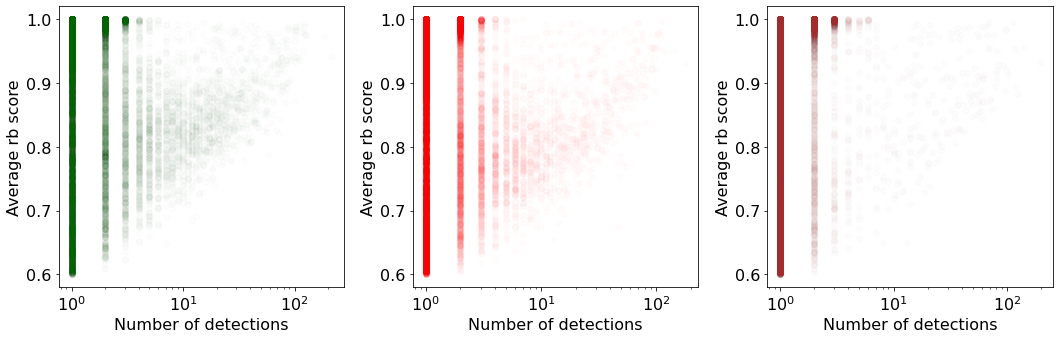

In [20]:
# Plotting the mean results
c = ['darkgreen', 'red', 'brown', 'limegreen', 'darkorange', 'peru']

fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in [0,1,2]:
    ax[i].semilogx( Cnum[i], Crbs_mean[i],  alpha=0.01, ls="", marker = 'o', color=c[i])
    ax[i].set_xlabel( "Number of detections" )
    ax[i].set_ylabel( "Average rb score" )
plt.tight_layout()
plt.savefig("./images/candrbVnum_COSMOS")

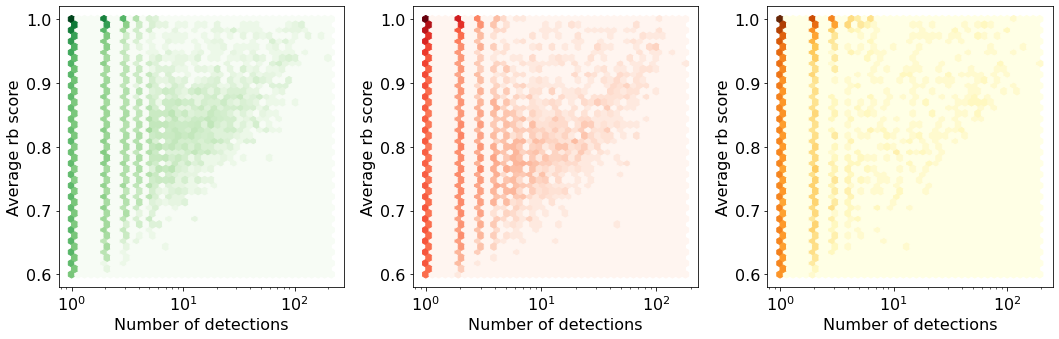

In [21]:
cmaps = ["Greens", "Reds", "YlOrBr"]

fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in [0,1,2]:
    ax[i].hexbin( Cnum[i], Crbs_mean[i], xscale='log', bins='log', gridsize=40, cmap=cmaps[i] )
    ax[i].set_xlabel( "Number of detections" )
    ax[i].set_ylabel( "Average rb score" )
plt.tight_layout()
# plt.savefig("./RBhexbin")